<a href="https://colab.research.google.com/github/souzamichel/ml_trading_test_code/blob/main/trading-backtest-code-vantharpe2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

🔄 Baixando dados de PETR4.SA para o período de 5y...
✅ Dados recebidos: 1244 registros.
🔎 Iniciando otimização entre 200 e 300 dias...

→ Testando canal de 200 dias...
📐 Executando estratégia com canal de 200 dias...


✅ Estratégia concluída. Capital final: R$ 26822.83
📈 Lucro bruto da estratégia: R$ 11904.24
📉 Max Drawdown: -0.3910
💰 Retorno: R$ 16822.83
🛡️ Fator de recuperação: 4.30
🏆 Novo melhor resultado encontrado com canal de 200 dias.

→ Testando canal de 205 dias...
📐 Executando estratégia com canal de 205 dias...
✅ Estratégia concluída. Capital final: R$ 26822.83
📈 Lucro bruto da estratégia: R$ 11904.24
📉 Max Drawdown: -0.3910
💰 Retorno: R$ 16822.83
🛡️ Fator de recuperação: 4.30

→ Testando canal de 210 dias...
📐 Executando estratégia com canal de 210 dias...
✅ Estratégia concluída. Capital final: R$ 26822.83
📈 Lucro bruto da estratégia: R$ 11904.24
📉 Max Drawdown: -0.3910
💰 Retorno: R$ 16822.83
🛡️ Fator de recuperação: 4.30

→ Testando canal de 215 dias...
📐 Executando estratégia com canal de 215 dias...
✅ Estratégia concluída. Capital final: R$ 26822.83
📈 Lucro bruto da estratégia: R$ 11904.24
📉 Max Drawdown: -0.3910
💰 Retorno: R$ 16822.83
🛡️ Fator de recuperação: 4.30

→ Testando canal de

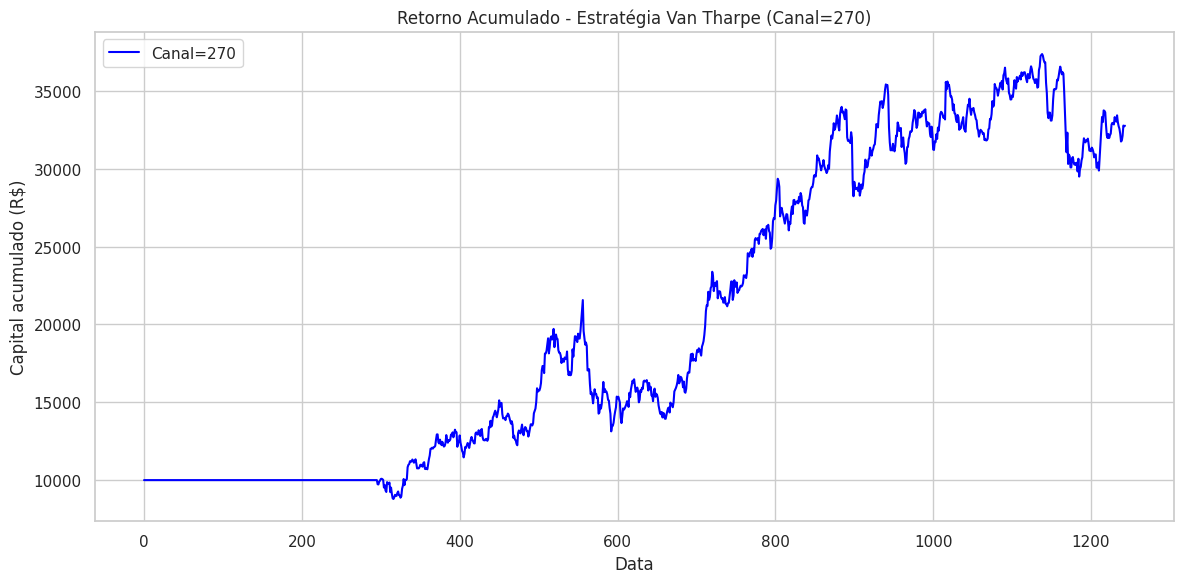

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
os.makedirs('/mnt/data', exist_ok=True)

# 💰 Capital inicial
initial_capital = 10000
position_size = 1  # Número de ações por operação

# 📊 Métrica de estabilidade
def stability_metric(equity):
    returns = np.diff(equity)
    std = np.std(returns)
    print(f"→ Desvio padrão da curva de lucro: {std:.6f}")
    return std

# 📈 Baixar dados da Yahoo Finance
def fetch_data(ticker="PETR4.SA", period="5y"):
    print(f"🔄 Baixando dados de {ticker} para o período de {period}...")
    df = yf.download(ticker, period=period, interval="1d", auto_adjust=True)
    df = df[['High', 'Low', 'Close']].dropna()
    print(f"✅ Dados recebidos: {len(df)} registros.")
    return df

# 🧮 Fator de recuperação
def recovery_factor(equity):
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()
    total_return = equity.iloc[-1] - initial_capital
    rf = total_return / abs(max_dd * initial_capital) if max_dd != 0 else np.nan
    print(f"→ Fator de recuperação calculado: {rf:.4f}")
    return rf

# ⚙️ Estratégia Van Tharpe com lista de trades
def van_tharpe_strategy(df, channel_length, position_size=1):
    print(f"📐 Executando estratégia com canal de {channel_length} dias...")
    df = df.copy().reset_index(drop=True)

    if len(df) < channel_length + 1:
        print("⚠️ Dados insuficientes para esse comprimento de canal.")
        df['Equity'] = [initial_capital] * len(df)
        return df, pd.DataFrame()

    df = df[['High', 'Low', 'Close']].ffill().bfill()

    df['High_Channel'] = df['High'].rolling(window=channel_length, min_periods=channel_length).max().shift(1)
    df['Low_Channel'] = df['Low'].rolling(window=channel_length, min_periods=channel_length).min().shift(1)

    positions = []
    for i in range(len(df)):
        try:
            close = float(df['Close'].iloc[i].item())
            high_channel = float(df['High_Channel'].iloc[i])
            low_channel = float(df['Low_Channel'].iloc[i])
        except:
            positions.append(np.nan)
            continue

        if np.isnan(close) or np.isnan(high_channel) or np.isnan(low_channel):
            positions.append(np.nan)
        elif close > high_channel:
            positions.append(1)
        elif close < low_channel:
            positions.append(-1)
        else:
            positions.append(np.nan)

    df['Position'] = pd.Series(positions).ffill().fillna(0)
    df['Return'] = df['Close'].pct_change().fillna(0)
    df['Strategy_Return'] = df['Position'].shift(1).fillna(0) * df['Return'] * position_size
    df['Equity'] = initial_capital * (1 + df['Strategy_Return']).cumprod()

    # 🧾 Lista de trades
    trades = []
    current_position = 0
    entry_price = None
    entry_date = None

    for i in range(1, len(df)):
        prev_pos = df['Position'].iloc[i - 1]
        curr_pos = df['Position'].iloc[i]
        price = df['Close'].iloc[i]

        if prev_pos == 0 and curr_pos != 0:
            entry_price = price
            entry_date = df.index[i]
            current_position = curr_pos

        elif prev_pos != 0 and curr_pos == 0 and entry_price is not None:
            exit_price = price
            exit_date = df.index[i]
            direction = 'Compra' if current_position > 0 else 'Venda'
            ret = (exit_price - entry_price) / entry_price if current_position > 0 else (entry_price - exit_price) / entry_price
            trades.append({
                'Entrada': entry_date,
                'Saída': exit_date,
                'Tipo': direction,
                'Preço Entrada': round(entry_price, 2),
                'Preço Saída': round(exit_price, 2),
                'Retorno (%)': round(ret * 100, 2)
            })
            entry_price = None
            current_position = 0

    # ✅ Fechar posição aberta no último dia
    if current_position != 0 and entry_price is not None:
        exit_price = df['Close'].iloc[-1]
        exit_date = df.index[-1]
        direction = 'Compra' if current_position > 0 else 'Venda'
        ret = (exit_price - entry_price) / entry_price if current_position > 0 else (entry_price - exit_price) / entry_price
        trades.append({
            'Entrada': entry_date,
            'Saída': exit_date,
            'Tipo': direction,
            'Preço Entrada': round(entry_price, 2),
            'Preço Saída': round(exit_price, 2),
            'Retorno (%)': round(ret * 100, 2)
        })

    print(f"✅ Estratégia concluída. Capital final: R$ {df['Equity'].iloc[-1]:.2f}")
    return df, pd.DataFrame(trades)

# 🔍 Otimização da parametrização
def optimize_strategy(df, min_len=200, max_len=300):
    print(f"🔎 Iniciando otimização entre {min_len} e {max_len} dias...")
    best_score = -np.inf
    best_len = None
    best_result = None
    best_trades = None

    for length in range(min_len, max_len + 1, 5):
        print(f"\n→ Testando canal de {length} dias...")
        result, trades = van_tharpe_strategy(df, length, position_size=position_size)
        if result is None or 'Equity' not in result or result['Equity'].isnull().any():
            print("⚠️ Resultado inválido, pulando...")
            continue

        equity = result['Equity']
        total_return = equity.iloc[-1] - initial_capital
        peak = equity.cummax()
        drawdown = (equity - peak) / peak
        max_dd = drawdown.min()
        rf = total_return / abs(max_dd * initial_capital) if max_dd != 0 else np.nan

        gross_profit = result['Strategy_Return'].sum()
        print(f"📈 Lucro bruto da estratégia: R$ {gross_profit * initial_capital:.2f}")
        print(f"📉 Max Drawdown: {max_dd:.4f}")
        print(f"💰 Retorno: R$ {total_return:.2f}")
        print(f"🛡️ Fator de recuperação: {rf:.2f}")

        if rf > best_score:
            print(f"🏆 Novo melhor resultado encontrado com canal de {length} dias.")
            best_score = rf
            best_len = length
            best_result = result.copy()
            best_trades = trades.copy()

    print(f"\n✅ Otimização concluída. Canal ideal: {best_len} dias com fator de recuperação {best_score:.2f}")
    return best_len, best_score, best_result, best_trades

# 🚀 Executar tudo
data = fetch_data("PETR4.SA", period="5y")
best_len, best_score, best_df, best_trades = optimize_strategy(data)
total_return = best_df['Equity'].iloc[-1] - initial_capital
recov = recovery_factor(best_df['Equity'])

print("\n📊 Resultados finais:")
print(f"📌 Comprimento do canal ótimo: {best_len} dias")
print(f"💰 Retorno total: R$ {total_return:.2f}")
print(f"🛡️ Fator de recuperação: {recov:.2f}")
print(f"📋 Total de trades: {len(best_trades)}")

# 📋 Exibir trades
print("\n📋 Lista de trades:")
print(best_trades)

# 📊 Gráfico do retorno acumulado
plt.figure(figsize=(12, 6))
plt.plot(best_df.index, best_df['Equity'], label=f'Canal={best_len}', color='blue')
plt.title(f'Retorno Acumulado - Estratégia Van Tharpe (Canal={best_len})')
plt.xlabel('Data')
plt.ylabel('Capital acumulado (R$)')
plt.legend()
plt.tight_layout()
plt.savefig('/mnt/data/van_tharpe_best_return.png')
plt.show()
